# Vision Investment Rental Worthiness Predictor.

In [9]:
import numpy as np
import sklearn 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
%matplotlib inline

In [10]:
train1 = pd.read_excel("datasets/dataset1.xlsx")
train2 = pd.read_excel("datasets/dataset2.xlsx")

In [20]:
train1.columns

Index(['Fico Score', 'Length of Employment (Months)',
       'Length of Current Residency  (Months)', 'Monthly Income',
       'Debt to Income percentage', 'Outcome'],
      dtype='object')

In [25]:
train2 = train2.drop(['Row Number '],axis=1)

In [43]:
train = pd.concat([train1,train2]).reset_index()
train.head()

,index,Fico Score,Length of Employment (Months),Length of Current Residency (Months),Monthly Income,Debt to Income percentage,Outcome
0,0,593,56,7,7920,50.313829,1.0
1,1,744,34,11,8748,24.693483,1.0
2,2,845,57,29,5582,79.617316,0.0
3,3,624,23,21,2418,81.520067,0.0
4,4,832,35,5,6637,85.491807,0.0


In [44]:
# percentage of 0s and 1s
(train.Outcome.value_counts()/750)*100

1.0    59.200000
0.0    40.666667
Name: Outcome, dtype: float64

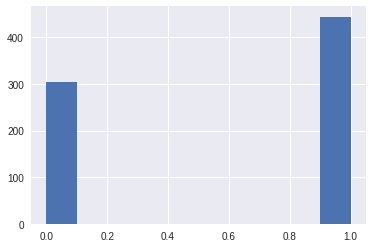

In [45]:
train.Outcome.loc[:,].hist()

In [55]:
X = train.iloc[:,1:-1] 

,Fico Score,Length of Employment (Months),Length of Current Residency (Months),Monthly Income,Debt to Income percentage
0,593,56,7,7920,50.313829
1,744,34,11,8748,24.693483
2,845,57,29,5582,79.617316
3,624,23,21,2418,81.520067
4,832,35,5,6637,85.491807
5,460,0,34,5720,2.727105
6,541,38,22,7666,52.292297
7,442,5,8,3984,50.136038
8,721,57,13,6385,71.117558
9,664,36,27,7202,92.654950


In [70]:
train = train.drop(train.index[27])

In [72]:
train.isnull().sum()

index                                    0
Fico Score                               0
Length of Employment (Months)            0
Length of Current Residency  (Months)    0
Monthly Income                           0
Debt to Income percentage                0
Outcome                                  0
dtype: int64